In [18]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
import seaborn as sns
# Mac OS를 이용하고 있기 떄문에 AppleGothic을 설정했습니다.
# 윈도우의 경우 다른 폰트를 사용해주셔야 합니다. 나눔폰트가 있는 경우 'NanumGothic' 없는 경우에는 'Malgun Gothic'을 사용해주세요.
matplotlib.rc('font', family='AppleGothic')
# mpl.rc('font', family='NanumGothic')

# 별도로, 폰트를 바꿀 경우 마이너스가 표시되지 않는 경우도 있는데 이를 막아주는 코드입니다.
matplotlib.rc('axes', unicode_minus=False)

# retina 옵션을 통해 해상도를 올립니다.
set_matplotlib_formats('retina')

In [2]:
data=pd.read_csv("../../data/jeju_data_ver1/201901-202003.csv",encoding='utf-8')

In [3]:
# 데이터 프레임 MAX 표시
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [4]:
#데이터 크기 확인
data.shape

(24697792, 12)

In [5]:
#데이터 테이블 확인
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [6]:
#Null값 확인 -> 결제자, 결제 매장 시정보 부족 
data.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

In [7]:
#결제 정보 AGE 확인
data.groupby('AGE')['CSTMR_CNT'].sum()

AGE
10s     13424782
20s    293663979
30s    340518467
40s    353287227
50s    327808177
60s    162639414
70s     39144291
Name: CSTMR_CNT, dtype: int64

### Pre-Processing

In [8]:
def make_datetime(row):
    return str(row)[:4] + '-' + str(row)[4:]

def make_year(row):
    row = str(row)
    return int(row[:4])

def make_month(row):
    row = str(row)
    return int(row[4:])

data['year_month'] = data['REG_YYMM'].apply(make_datetime)
data['year'] = data['REG_YYMM'].apply(make_year)
data['month'] = data['REG_YYMM'].apply(make_month)
print(data.shape)
data[['REG_YYMM','year_month','year','month']].head()

(24697792, 15)


,REG_YYMM,year_month,year,month
0,201901,2019-01,2019,1
1,201901,2019-01,2019,1
2,201901,2019-01,2019,1
3,201901,2019-01,2019,1
4,201901,2019-01,2019,1


In [9]:
data['AVG_AMT']=round(data['AMT']/data['CNT'],0)

In [10]:
data[['AMT','CNT','AVG_AMT']]

,AMT,CNT,AVG_AMT
0,311200,4,77800.0
1,1374500,8,171812.0
2,818700,6,136450.0
3,1717000,5,343400.0
4,1047300,3,349100.0
...,...,...,...
24697787,43300,4,10825.0
24697788,35000,3,11667.0
24697789,188000,6,31333.0
24697790,99000,6,16500.0


In [11]:
data.groupby(['CARD_SIDO_NM','HOM_SIDO_NM'])['AMT'].sum().unstack(level=1)

HOM_SIDO_NM,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
CARD_SIDO_NM,,,,,,,,,,,,,,,,,
강원,1204443934968,162823451073,3121511108,6504213645,1738152912,5805140672,3343747369,3404369910,152023451502,1074837768,1933894243,23471220043,847792240,1684600732,669440847,5225338407,11496202480
경기,42667789268,12202350438264,20857238950,18204994685,15451029587,19154401989,20251119829,17693232603,1326661365372,6885543532,7295160002,355408975112,10710624804,18749736527,6030819507,80086121737,33426643101
경남,385464373,12582944992,3108803198778,11417012567,3452626287,30598582170,2603771058,261067573951,8493664532,690838074,25885548752,2485385854,8979367343,4073147647,682741509,2140243737,787918240
경북,4240647160,33587406012,31397080926,2234756004003,1421834859,315943540883,8040351980,43693770514,18235856818,1610740231,52474883435,6356946667,1450547057,1215765213,708717547,5466734350,7019767593
광주,106904663,6838370402,745553001,329565782,1582501232195,620260243,853587430,842353444,6807672272,309313092,161961988,1420809424,92553193177,9284961381,1108859354,987647322,178115764
대구,522842517,8410164079,14082604097,156702549057,816069787,2810736165542,1541601056,6838989361,8721064201,303250015,5872466604,1278622742,577097199,554597278,774839596,1597485095,733944378
대전,919765723,19246146457,2398037878,3175262986,1853526566,3224397971,986590235182,2537864740,17878473770,35839983729,772866783,4026090449,966615205,5363769516,804111841,28774156834,14542155086
부산,2252536247,44301010576,359195551560,55516174563,4944751683,41678269646,4413448461,3821544401090,49297292542,1210343321,73058424964,8648568817,6330579513,2904101257,8529224615,5067342560,2414010126
서울,115109186893,2405671130423,219623968790,124609773225,143787026407,145753742230,117699536715,287606166794,10092021194371,33258338290,82682687943,400567231568,89337643193,118763376872,80901725058,130776599318,88961720941


In [21]:
# 코로나 이전과 이후 컬럼 추가
data.loc[data['year_month'] >='2020-02','post_corona'] = int(1)
data.loc[data['year_month'] <'2020-02','post_corona'] = int(0)

In [46]:
#FLC:가구생애주기
# 1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구
flc_1=data[data['FLC'] == 1]
flc_2=data[data['FLC'] == 2]
flc_3=data[data['FLC'] == 3]
flc_4=data[data['FLC'] == 4]
flc_5=data[data['FLC'] == 5]

In [52]:
print("1인가구",flc_1['AMT'].sum())
print("영유아 자녀가구",flc_2['AMT'].sum())
print("중고생 자녀가구",flc_3['AMT'].sum())
print("성인 자녀가구",flc_4['AMT'].sum())
print("노년 가구",flc_5['AMT'].sum())

1인가구 7371507278072
영유아 자녀가구 12619055902225
중고생 자녀가구 11538603588734
성인 자녀가구 17864707502682
노년 가구 10902152777293


### 가구 구성원 별 지출 현황

- 1인가구: 소매업 중심으로 증가 

In [88]:
flc_1.groupby(['year_month','STD_CLSS_NM'])['AMT'].sum().div(100000).unstack(level=1).round(0).to_csv("../../result/0629.csv",encoding='utf-8-sig')

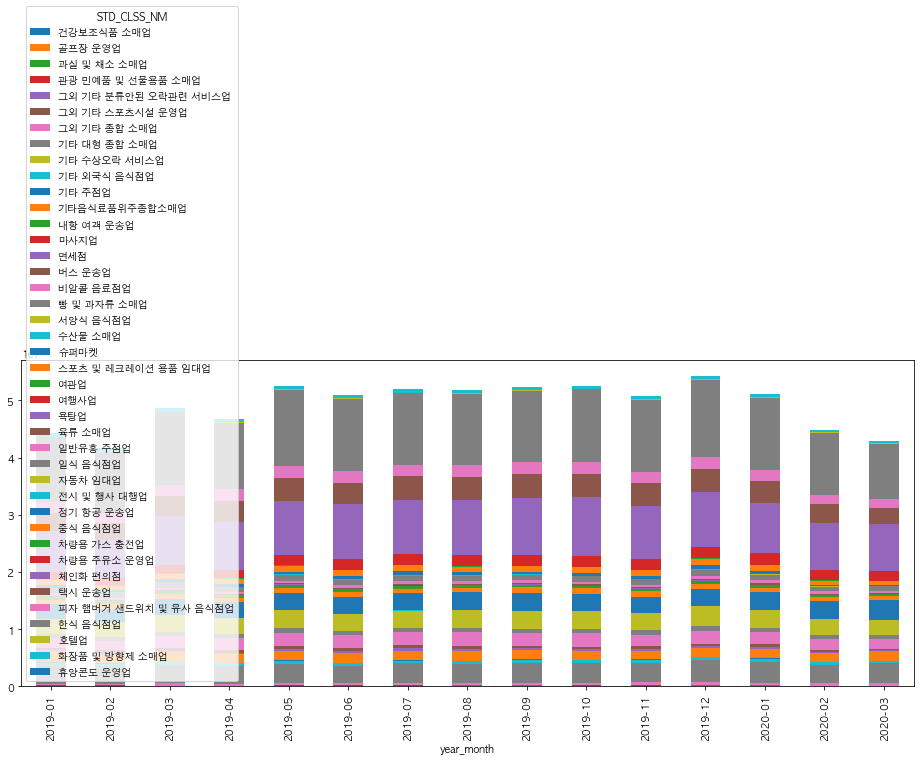

In [63]:
flc_1.groupby(['year_month','STD_CLSS_NM'])['AMT'].sum().div(10000).unstack(level=1).round(0).plot.bar(stacked=True,figsize=(16,6))

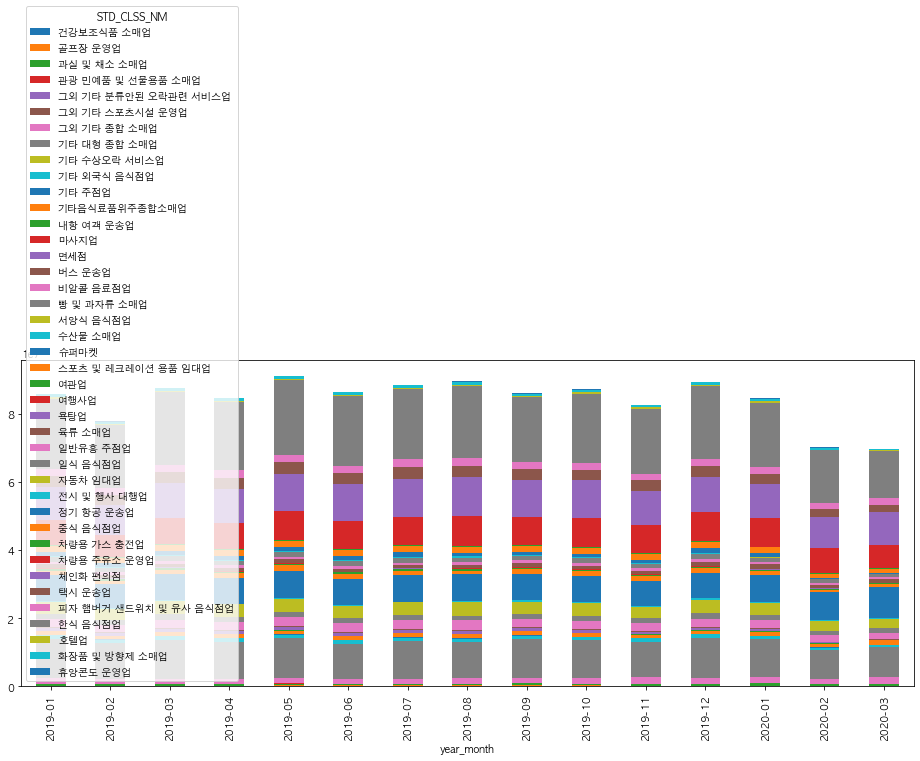

In [65]:
flc_2.groupby(['year_month','STD_CLSS_NM'])['AMT'].sum().div(10000).unstack(level=1).round(0).plot.bar(stacked=True,figsize=(16,6))

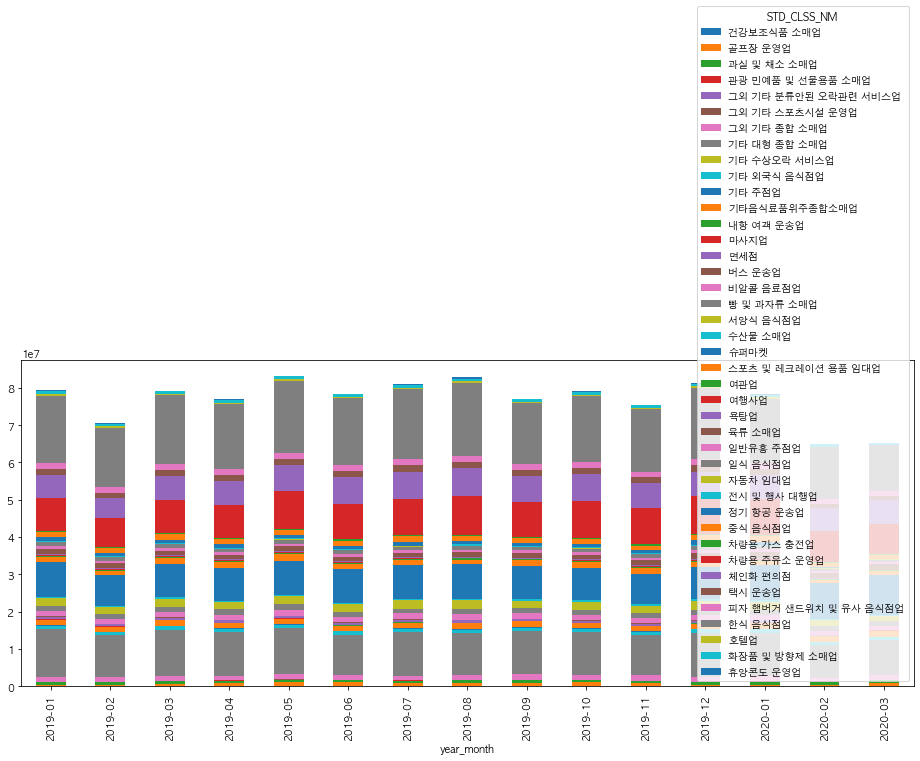

In [66]:
flc_3.groupby(['year_month','STD_CLSS_NM'])['AMT'].sum().div(10000).unstack(level=1).round(0).plot.bar(stacked=True,figsize=(16,6))

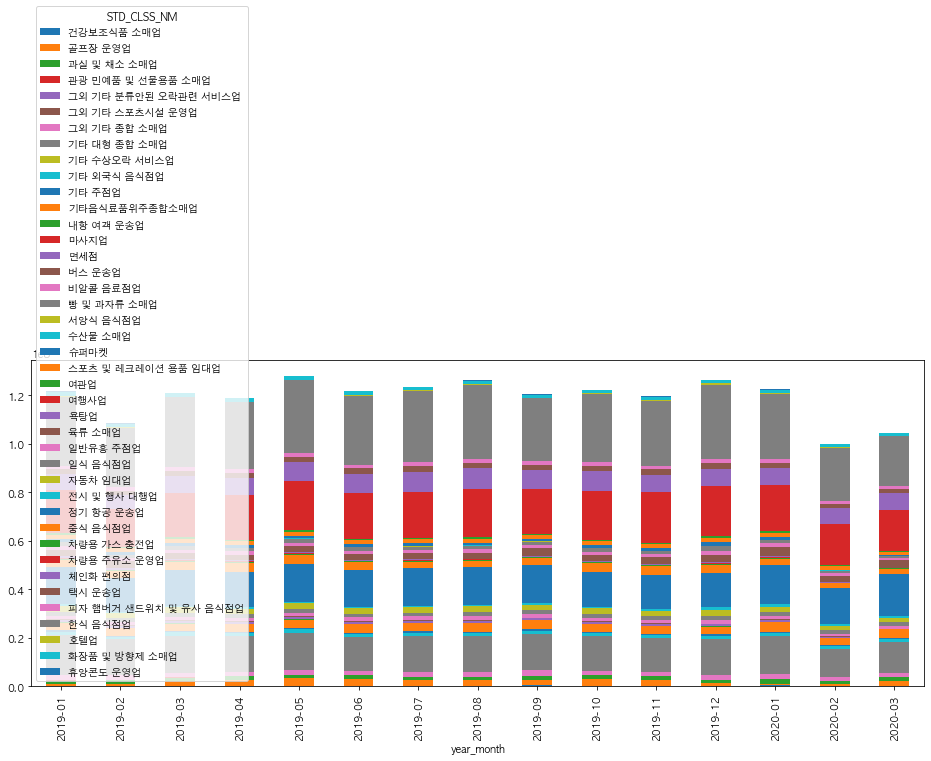

In [67]:
flc_4.groupby(['year_month','STD_CLSS_NM'])['AMT'].sum().div(10000).unstack(level=1).round(0).plot.bar(stacked=True,figsize=(16,6))

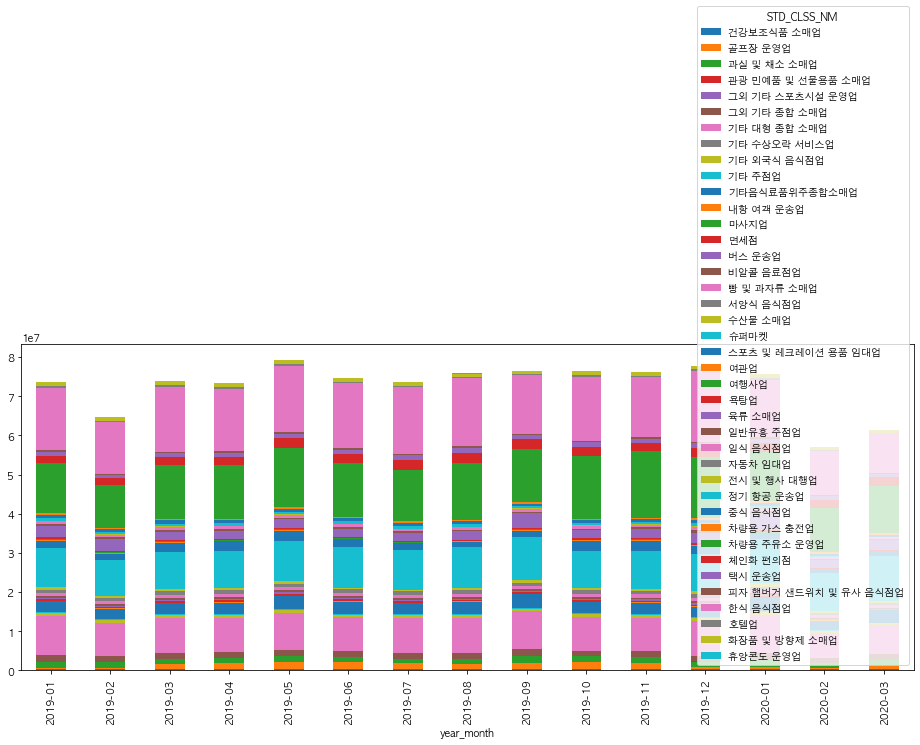

In [68]:
flc_5.groupby(['year_month','STD_CLSS_NM'])['AMT'].sum().div(10000).unstack(level=1).round(0).plot.bar(stacked=True,figsize=(16,6))

### Model에 넣을 Feature 만들기

### 1) Missing data processing

- Null값 처리
- categorical 데이터 -> labeling or one hot encoding

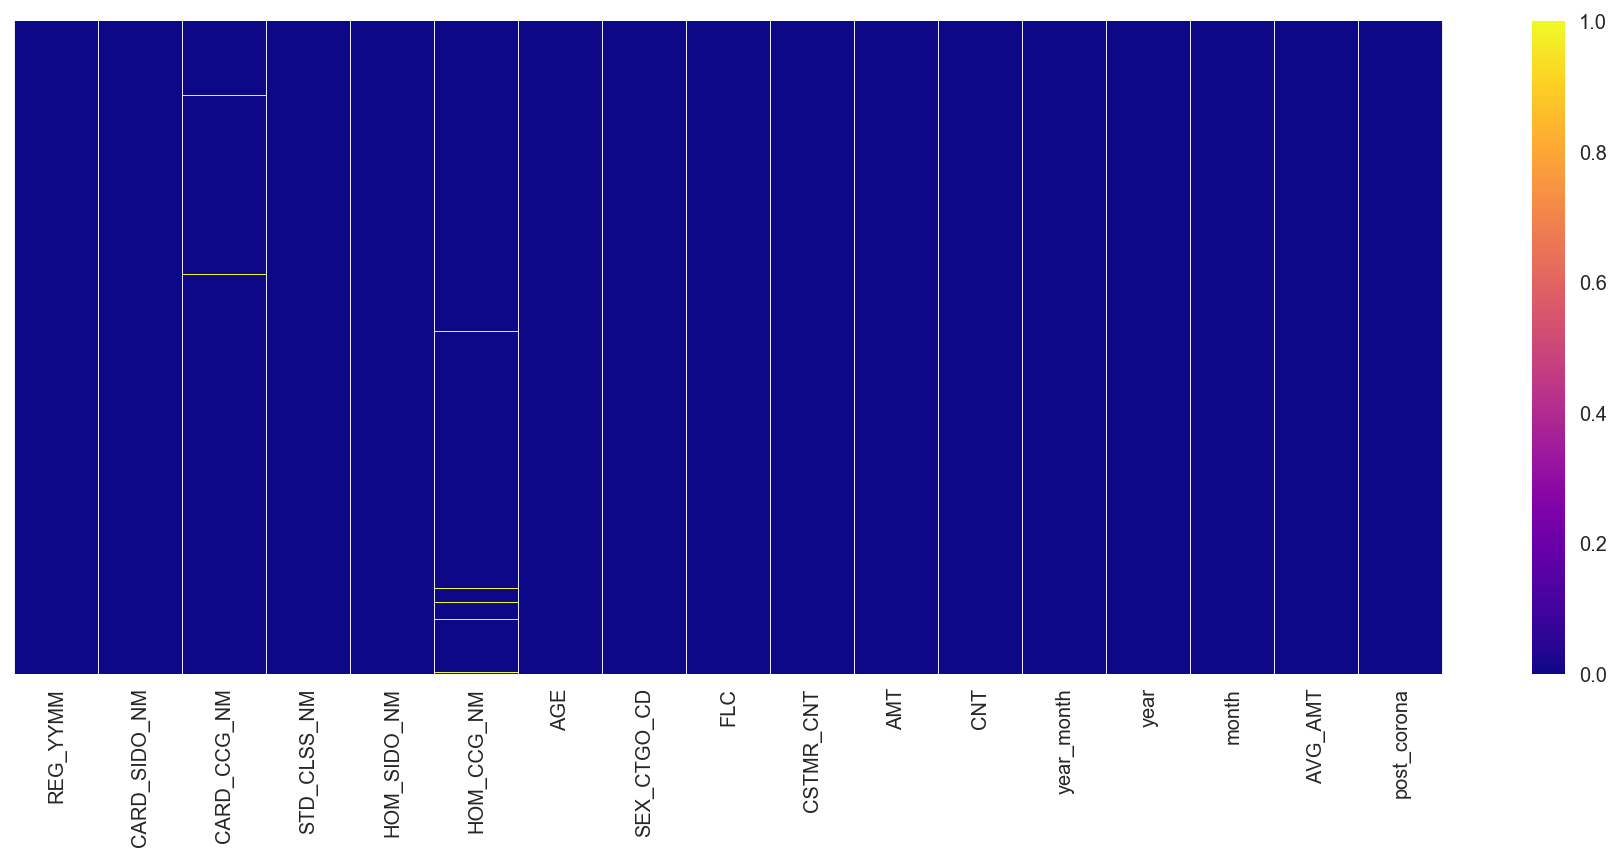

In [19]:
plt.style.use('seaborn')
plt.figure(figsize=(16,6))
sns.heatmap(data.isnull(), yticklabels = False, cmap='plasma')

In [22]:
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year_month,year,month,AVG_AMT,post_corona
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019-01,2019,1,77800.0,0.0
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019-01,2019,1,171812.0,0.0
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019-01,2019,1,136450.0,0.0
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019-01,2019,1,343400.0,0.0
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019-01,2019,1,349100.0,0.0


## 월 별 카드 취소 건

- CSTMR_CNT (이용고객수) 가 CNT (이용건수) 보다 많은 경우 카드내역 취소한 경우
- 2020년 1월 카드취소가 가장많으며 (전년대비 1500건 증가) 그 다음으론 2019년 7,9,8월 각각 높음 (휴가철이라 높은가?)
- 2020년 2월은 1월보다는 카드취소가 적었으며 작년 대비 200건 정도 증가
- 2020년 3월은 카드취소가 가장 적었음 

### 왜 2020년 1월은 가장 많았는데, 2월 3월은 그것보단 적었을까?
- 1월 말 설 연휴 코로나 발생으로 카드 취소건수가 폭증했으며 2월,3월에는 코로나 터진 직후로 예약자가 급감했을것이고 사전에 예약해두었던 사람들만 취소했을 것

In [34]:
data.loc[data['CSTMR_CNT'] > data['CNT'],'REG_YYMM'].value_counts()

202001    6819
201907    6594
201909    6591
201908    6420
202002    6001
201902    5866
201905    5706
201910    5696
201904    5551
201906    5522
201901    5393
201903    5253
201912    5153
201911    4821
202003    3650
Name: REG_YYMM, dtype: int64

## Categorical Data Processing

- object형 데이터들은 ML에 넣을 수 없고, 상관관계 알수없기 때문에 labeling 해준다

In [45]:
data2=data[['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC','CSTMR_CNT','AMT']]

In [47]:
data2['CARD_SIDO_NM'].unique()

array(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산',
       '인천', '전남', '전북', '제주', '충남', '충북'], dtype=object)

In [48]:
from sklearn.preprocessing import LabelEncoder

#null 제거
data2.dropna(inplace=True)

# Get list of categorical variables
s = (data2.dtypes == 'object')
object_cols = list(s[s].index)

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    data2[col] = label_encoder.fit_transform(data2[col])


<ipython-input-48-c35cdbe68280>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.dropna(inplace=True)
<ipython-input-48-c35cdbe68280>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[col] = label_encoder.fit_transform(data2[col])


In [50]:
data2['CARD_SIDO_NM'].value_counts()

8     6230969
1     5170076
7     2026439
10    1273892
0     1226136
2     1220208
3     1200053
14    1155954
12     822623
15     819392
11     816643
5      756700
6      504056
13     494432
4      430730
9      322225
Name: CARD_SIDO_NM, dtype: int64

In [51]:
print(data.shape)
print(data2.shape)

(24697792, 17)
(24470528, 10)


### 피처간의 상관관계

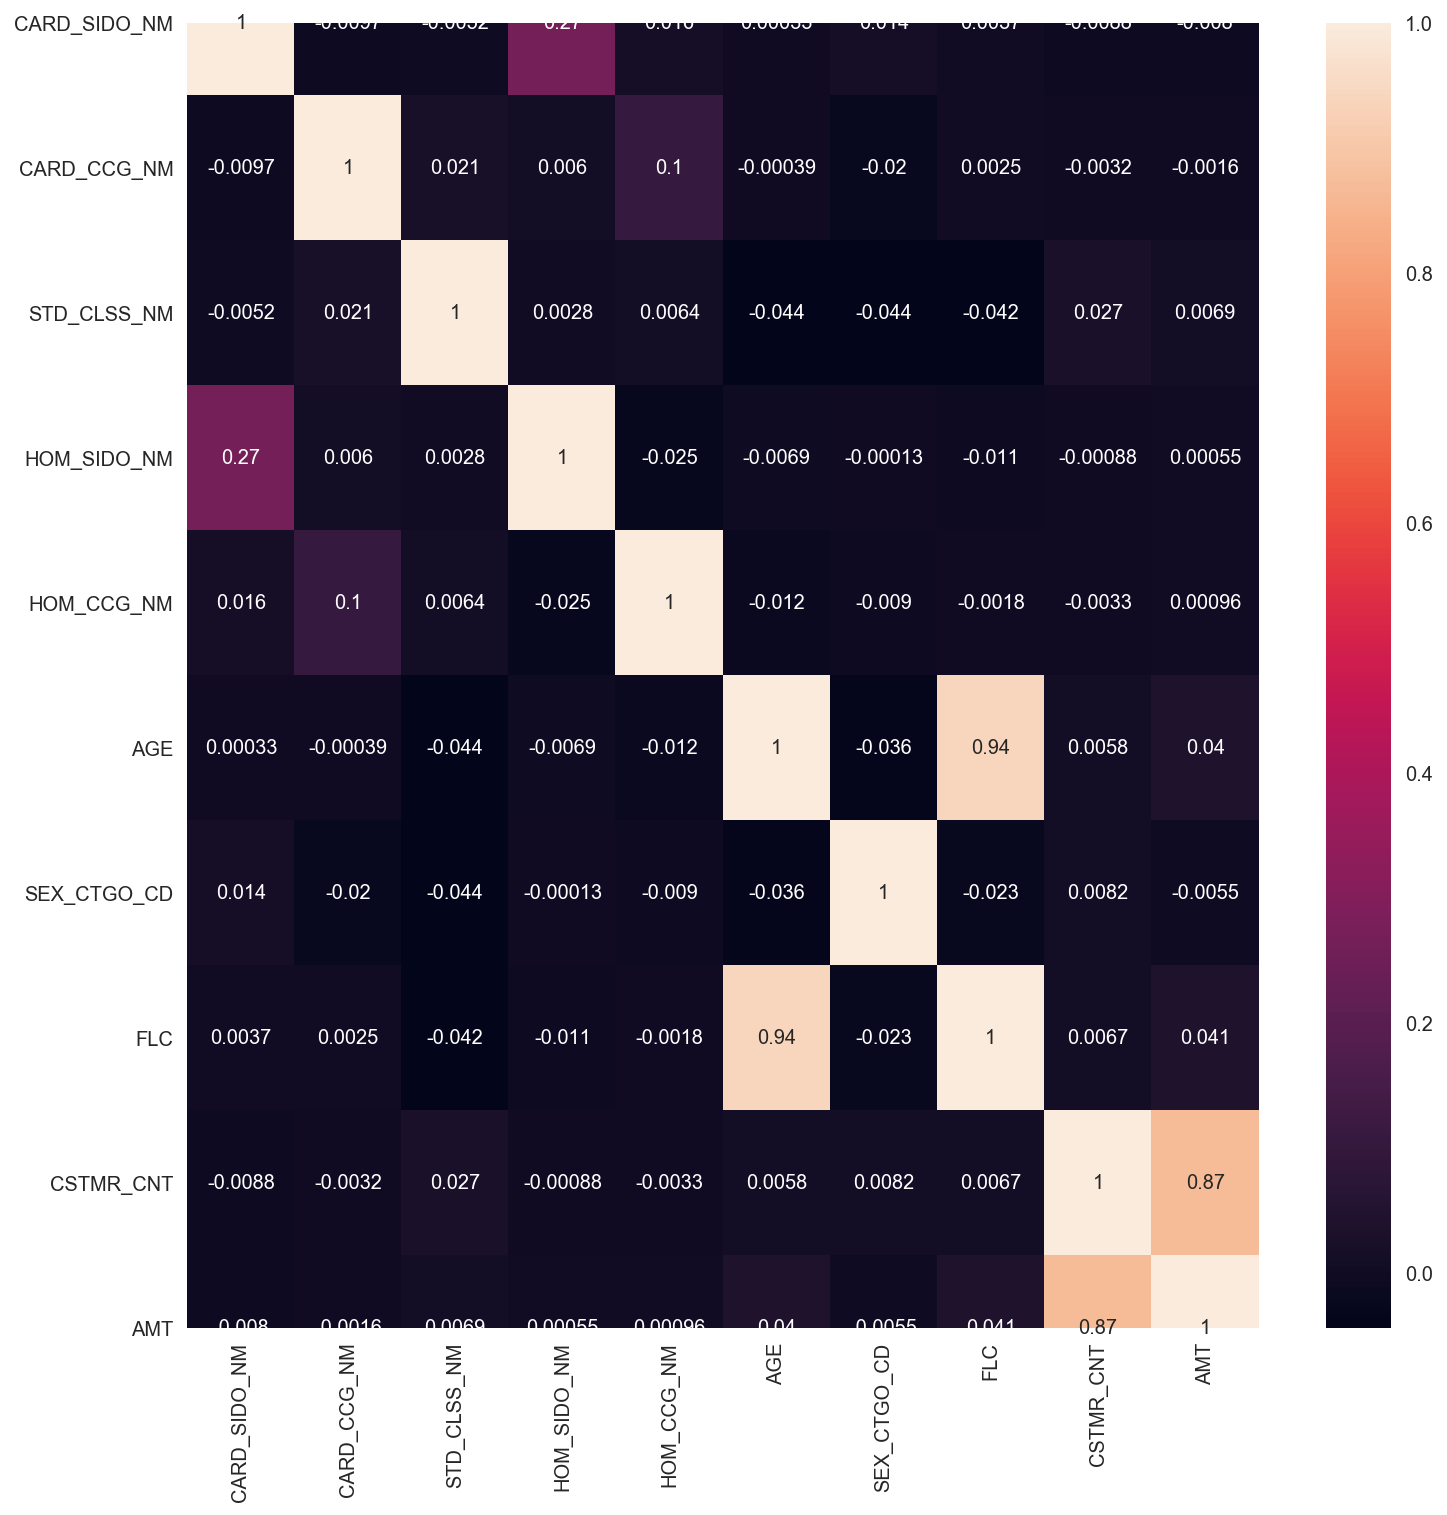

In [54]:
plt.figure(figsize=(12,12))
sns.heatmap(data2.corr(), annot=True)

- AMT 와 관계 높은 것 : CSTMR_CNT, FLC, AGE
- AMT 와 관계 낮은 것 : SEX_CTGO_CD, HOM_CCG_NM,HOM_SIDO_NM

- HOM_SIDO_NM 과 CARD_SIDO_NM 연관성 높지만 꼭 일치하는 것은 아님 
- AGE 와 FLC 관계 높음 -> 연령대 별로 가구형태 패턴이 있는걸까?

### AGE 와 FLC 관계

*FLC: 가구 생애주기

1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구

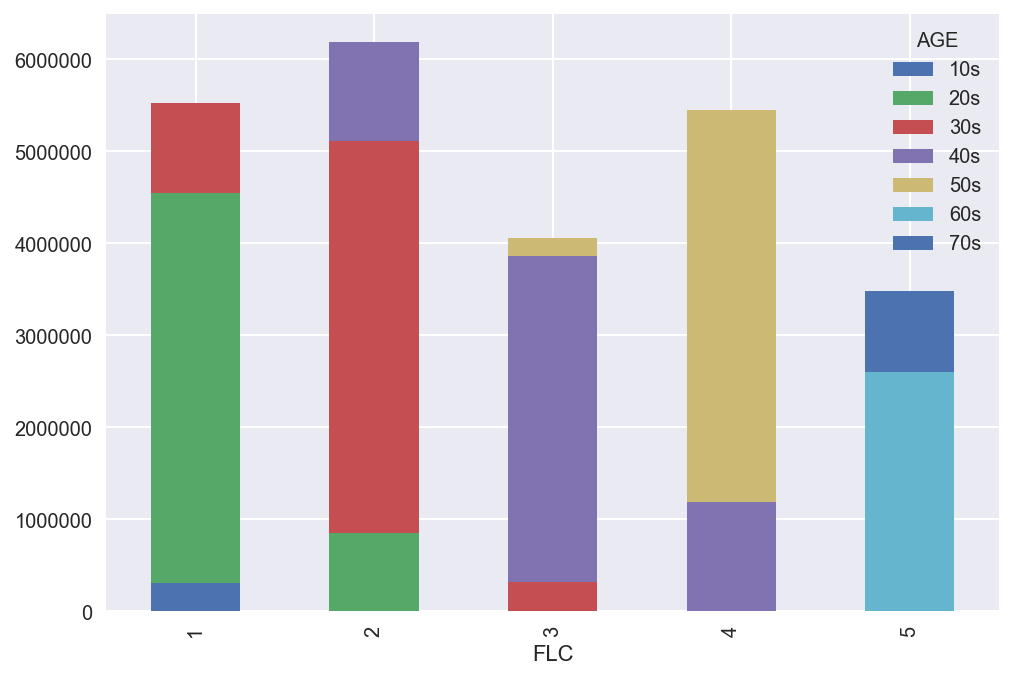

In [60]:
data.groupby('FLC')['AGE'].value_counts().unstack(level=1).plot.bar(stacked=True)

- 연령과 가구형태를 묶어서 Life 변수로 사용할 수 있지않을까? (1인가구 20대와, 영유아 자녀를 둔 20대는 다른 life style)

In [61]:
data.loc[data['AGE'] == '10s','FLC'].value_counts()

1    314674
Name: FLC, dtype: int64